In [77]:
from typing import Optional

import numpy as np
from numpy.typing import ArrayLike
from tabulate import tabulate
import matplotlib.pyplot as plt

In [8]:
# TODO: vector correct/wrong and order and uncertainty
num_ood_obs = 5000
num_id_obs = 5000
id_accuracy = 0.95
shuffle_rate = 0.1


In [12]:
num_id_correct = int(num_id_obs * id_accuracy)
num_id_wrong = num_id_obs - num_id_correct

In [50]:
y_pred_correct = np.concatenate(
    (np.zeros((num_ood_obs)), np.zeros((num_id_wrong)), np.ones((num_id_correct)))
)

y_pred_uncertainty = np.concatenate(
    (
        np.random.normal(2.5, 0.5, num_ood_obs),
        np.random.normal(1.5, 0.5, num_id_wrong),
        np.random.normal(0.1, 0.1, num_id_correct),
    )
)
# make negative values 0
y_pred_uncertainty = np.maximum(y_pred_uncertainty, 0)

np.random.seed(seed=44)
random_draws = np.random.random(y_pred_uncertainty.size)
y_reject_order = np.lexsort((random_draws, y_pred_uncertainty))
y_reject_order = np.flip(y_reject_order, axis=0)

In [51]:
y_pred_uncertainty.shape

(10000,)

In [63]:
def confusion_matrix_rej(
    correct: ArrayLike,
    threshold: float,
    reject_order: Optional[ArrayLike] = None,
    unc_ary: Optional[ArrayLike] = None,
    relative: bool = True,
    show: bool = False,
    seed: int = 44,
) -> tuple[int, int, int, int]:
    """Compute confusion matrix with 2 axes: (i) correct/incorrect, (ii) rejected/non-rejected.

    Parameters
    ----------
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    threshold : float
        Rejection threshold.
    reject_order : ArrayLike
        1D array (`float` type) containing indices to reject, first index rejected first.
    unc_ary : ArrayLike
        1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
    relative : bool, optional
        Use relative rejection, otherwise absolute rejection.
        Default: True
    show : bool, optional
        Print confusion matrix to console.
        Default: False
    seed: int, optional
        Seed value for random rejection.
        Default 44

    Returns
    -------
    n_cor_rej : int
        Number of correct observations that are rejected.
    n_cor_nonrej : int
        Number of correct observations that are not rejected.
    n_incor_rej : int
        Number of incorrect observations that are rejected.
    n_incor_nonrej : int
        Number of incorrect observations that are not rejected.
    """
    # check inputs
    if relative:
        if unc_ary is not None and reject_order is not None:
            raise ValueError(
                "For relative rejection, either unc_ary or reject_order must be provided."
            )
        if unc_ary is None and reject_order is None:
            raise ValueError(
                "For relative rejection, either unc_ary or reject_order must be provided."
            )
    else:
        if unc_ary is None:
            raise ValueError("For absolute rejection, only unc_ary must be provided.")

    if threshold < 0:
        raise ValueError("Threshold must be non-negative.")
    if relative and threshold > 1:
        raise ValueError("Threshold must be less than or equal to 1.")

    # axis 0: correct or incorrect
    idx_correct = np.where(correct == 1.0)[0]
    idx_incorrect = np.where(correct == 0.0)[0]

    # axis 1: rejected or non-rejected
    if relative:
        # relative rejection
        n_preds_rej = int(threshold * correct.size)
        if unc_ary is not None:
            # use uncertainty array
            # sort by unc_ary, then by random numbers random_draws
            # -> if values equal e.g. 1.0 -> rejected randomly
            np.random.seed(seed=seed)
            random_draws = np.random.random(correct.size)
            idx = np.lexsort((random_draws, unc_ary))
            idx = np.flip(idx, axis=0)
            idx_rej = idx[:n_preds_rej]
            idx_nonrej = idx[n_preds_rej:]
        elif reject_order is not None:
            # use reject_order
            idx_rej = reject_order[:n_preds_rej]
            idx_nonrej = reject_order[n_preds_rej:]
    else:
        # absolute rejection
        y_reject = np.where(unc_ary >= threshold, 1, 0)
        idx_rej = np.where(y_reject == 1)[0]
        idx_nonrej = np.where(y_reject == 0)[0]

    # intersections
    idx_cor_rej = np.intersect1d(idx_correct, idx_rej)
    idx_cor_nonrej = np.intersect1d(idx_correct, idx_nonrej)
    idx_incor_rej = np.intersect1d(idx_incorrect, idx_rej)
    idx_incor_nonrej = np.intersect1d(idx_incorrect, idx_nonrej)
    n_cor_rej = idx_cor_rej.shape[0]
    n_cor_nonrej = idx_cor_nonrej.shape[0]
    n_incor_rej = idx_incor_rej.shape[0]
    n_incor_nonrej = idx_incor_nonrej.shape[0]
    if show:
        print(
            tabulate(
                [
                    ["", "Non-rejected", "Rejected"],
                    ["Correct", n_cor_nonrej, n_cor_rej],
                    ["Incorrect", n_incor_nonrej, n_incor_rej],
                ],
                headers="firstrow",
            )
        )
    return n_cor_rej, n_cor_nonrej, n_incor_rej, n_incor_nonrej


# print(confusion_matrix_rej(
#     correct=y_pred_correct,
#     threshold=0.7,
#     reject_order=y_reject_order,
#     unc_ary=None,
#     relative=True,
#     show=True,
#     seed=44,
# ))

# print(confusion_matrix_rej(
#     correct=y_pred_correct,
#     threshold=0.5,
#     reject_order=None,
#     unc_ary=y_pred_uncertainty,
#     relative=True,
#     show=True,
#     seed=44,
# ))

# print(confusion_matrix_rej(
#     correct=y_pred_correct,
#     threshold=2.0,
#     reject_order=None,
#     unc_ary=y_pred_uncertainty,
#     relative=False,
#     show=True,
#     seed=44,
# ))

In [78]:
def compute_metrics_rej(
    threshold: float,
    correct: ArrayLike,
    reject_order: Optional[ArrayLike],
    unc_ary: Optional[ArrayLike],
    relative: bool = True,
    show: bool = True,
    seed: int = 44,
) -> tuple[float, float, float]:
    """Compute 3 rejection metrics using relative or absolute threshold:
    - non-rejeced accuracy (NRA)
    - classification quality (CQ)
    - rejection quality (RQ)
    
    Parameters
    ----------
    threshold : float
        Rejection threshold.
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    reject_order : ArrayLike
        1D array (`float` type) containing indices to reject, first index rejected first.
    unc_ary : ndarray
        1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
    relative : bool, optional
        Use relative rejection, otherwise absolute rejection.
        Default: True
    show : bool, optional
        Print confusion matrix to console.
        Default: True
    seed: int, optional
        Seed value for random rejection.
        Default 44
    
    Returns
    -------
    nonrej_acc : float
        Non-rejeced accuracy (NRA).
    class_quality : float
        Classification quality (CQ).
    rej_quality : float
        Rejection quality (RQ).
    Notes
    -----
    - rejection quality is undefined when `n_cor_rej=0`
        - if any observation is rejected: RQ = positive infinite
        - if no sample is rejected: RQ = 1
        - see: `Condessa et al. (2017) <https://doi.org/10.1016/j.patcog.2016.10.011>`_
    """
    n_cor_rej, n_cor_nonrej, n_incor_rej, n_incor_nonrej = confusion_matrix_rej(
        correct=correct,
        threshold=threshold,
        reject_order=reject_order,
        unc_ary=unc_ary,
        show=show,
        relative=relative,
        seed=seed,
    )

    # 3 metrics
    try:
        nonrej_acc = n_cor_nonrej / (n_incor_nonrej + n_cor_nonrej)
    except ZeroDivisionError:
        nonrej_acc = np.inf  # invalid
    try:
        class_quality = (n_cor_nonrej + n_incor_rej) / (
            n_cor_rej + n_cor_nonrej + n_incor_rej + n_incor_nonrej
        )
    except ZeroDivisionError:
        class_quality = np.inf  # invalid
    try:
        rej_quality = (n_incor_rej / n_cor_rej) / (
            (n_incor_rej + n_incor_nonrej) / (n_cor_rej + n_cor_nonrej)
        )
    except ZeroDivisionError:
        if (n_incor_rej + n_cor_rej) > 0:
            rej_quality = np.inf
        else:
            rej_quality = 1.0
    if show:
        data = [[nonrej_acc, class_quality, rej_quality]]
        print( # TODO: use logging instead of print
            "\n"
            + tabulate(
                data,
                headers=[
                    "Non-rejected accuracy",
                    "Classification quality",
                    "Rejection quality",
                ],
                floatfmt=".4f",
            )
        )
    return nonrej_acc, class_quality, rej_quality

print(compute_metrics_rej(
    threshold=0.3,
    correct=y_pred_correct,
    reject_order=y_reject_order,
    unc_ary=None,
    relative=True,
    show=True,
    seed=44,
))

# print(compute_metrics_rej(
#     threshold=0.5,
#     correct=y_pred_correct,
#     reject_order=None,
#     unc_ary=y_pred_uncertainty,
#     relative=True,
#     show=True,
#     seed=44,
# ))

# print(compute_metrics_rej(
#     threshold=2.0,
#     correct=y_pred_correct,
#     reject_order=None,
#     unc_ary=y_pred_uncertainty,
#     relative=False,
#     show=True,
#     seed=44,
# ))

             Non-rejected    Rejected
---------  --------------  ----------
Correct              4750           0
Incorrect            2250        3000

  Non-rejected accuracy    Classification quality    Rejection quality
-----------------------  ------------------------  -------------------
                 0.6786                    0.7750                  inf
(0.6785714285714286, 0.775, inf)


In [74]:
# class NonRejectedAccuracy:
#     def __init__(
#         self,
#         relative: bool = True,
#         seed: int = 44,
#     ):
#         self.relative = relative
#         self.seed = seed

#     def __call__(
#         self,
#         correct: ArrayLike,
#         threshold: float,
#         reject_order: Optional[ArrayLike],
#         unc_ary: Optional[ArrayLike],
#     ):
#         _, n_cor_nonrej, _, n_incor_nonrej = confusion_matrix_rej(
#             correct=correct,
#             threshold=threshold,
#             reject_order=reject_order,
#             unc_ary=unc_ary,
#             show=False,
#             relative=self.relative,
#             seed=self.seed,
#         )
#         try:
#             nonrej_acc = n_cor_nonrej / (n_incor_nonrej + n_cor_nonrej)
#         except ZeroDivisionError:
#             nonrej_acc = np.inf  # invalid
#         return nonrej_acc


# nra = NonRejectedAccuracy(relative=True, seed=44)
# print(nra(y_pred_correct, 0.4, y_reject_order, None))

In [75]:
def non_rejected_accuracy(
    correct: ArrayLike,
    threshold: float,
    reject_order: Optional[ArrayLike],
    unc_ary: Optional[ArrayLike],
    relative: bool = True,
    seed: int = 44,
) -> float:
    """Compute non-rejected accuracy (NRA).

    Parameters
    ----------
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    threshold : float
        Rejection threshold.
    reject_order : ArrayLike
        1D array (`float` type) containing indices to reject, first index rejected first.
    unc_ary : ndarray
        1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
    relative : bool, optional
        Use relative rejection, otherwise absolute rejection.
        Default: True
    seed: int, optional
        Seed value for random rejection.
        Default 44

    Returns
    -------
    float
        Value of non-rejected accuracy.
    """    
    _, n_cor_nonrej, _, n_incor_nonrej = confusion_matrix_rej(
        correct=correct,
        threshold=threshold,
        reject_order=reject_order,
        unc_ary=unc_ary,
        show=False,
        relative=relative,
        seed=seed,
    )
    try:
        nonrej_acc = n_cor_nonrej / (n_incor_nonrej + n_cor_nonrej)
    except ZeroDivisionError:
        nonrej_acc = np.inf  # invalid
    return nonrej_acc

def classification_quality(
        correct: ArrayLike,
    threshold: float,
    reject_order: Optional[ArrayLike],
    unc_ary: Optional[ArrayLike],
    relative: bool = True,
    seed: int = 44,
) -> float:
    """Compute classification quality (CQ).

    Parameters
    ----------
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    threshold : float
        Rejection threshold.
    reject_order : ArrayLike
        1D array (`float` type) containing indices to reject, first index rejected first.
    unc_ary : ndarray
        1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
    relative : bool, optional
        Use relative rejection, otherwise absolute rejection.
        Default: True
    seed: int, optional
        Seed value for random rejection.
        Default 44

    Returns
    -------
    float
        Value of classification quality.
    """    
    n_cor_rej, n_cor_nonrej, n_incor_rej, n_incor_nonrej = confusion_matrix_rej(
        correct=correct,
        threshold=threshold,
        reject_order=reject_order,
        unc_ary=unc_ary,
        show=False,
        relative=relative,
        seed=seed,
    )
    try:
        class_quality = (n_cor_nonrej + n_incor_rej) / (
            n_cor_rej + n_cor_nonrej + n_incor_rej + n_incor_nonrej
        )
    except ZeroDivisionError:
        class_quality = np.inf  # invalid
    return class_quality

def classification_quality(
        correct: ArrayLike,
    threshold: float,
    reject_order: Optional[ArrayLike],
    unc_ary: Optional[ArrayLike],
    relative: bool = True,
    seed: int = 44,
) -> float:
    """Compute rejection quality (CQ).

    Parameters
    ----------
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    threshold : float
        Rejection threshold.
    reject_order : ArrayLike
        1D array (`float` type) containing indices to reject, first index rejected first.
    unc_ary : ndarray
        1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
    relative : bool, optional
        Use relative rejection, otherwise absolute rejection.
        Default: True
    seed: int, optional
        Seed value for random rejection.
        Default 44

    Returns
    -------
    float
        Value of rejection quality.
    """    
    n_cor_rej, n_cor_nonrej, n_incor_rej, n_incor_nonrej = confusion_matrix_rej(
        correct=correct,
        threshold=threshold,
        reject_order=reject_order,
        unc_ary=unc_ary,
        show=False,
        relative=relative,
        seed=seed,
    )
    try:
        rej_quality = (n_incor_rej / n_cor_rej) / (
            (n_incor_rej + n_incor_nonrej) / (n_cor_rej + n_cor_nonrej)
        )
    except ZeroDivisionError:
        if (n_incor_rej + n_cor_rej) > 0:
            rej_quality = np.inf
        else:
            rej_quality = 1.0
    return rej_quality

In [ ]:

print(non_rejected_accuracy(y_pred_correct, 0.4, y_reject_order, None))

<Axes: xlabel='Absolute threshold', ylabel='Metric'>

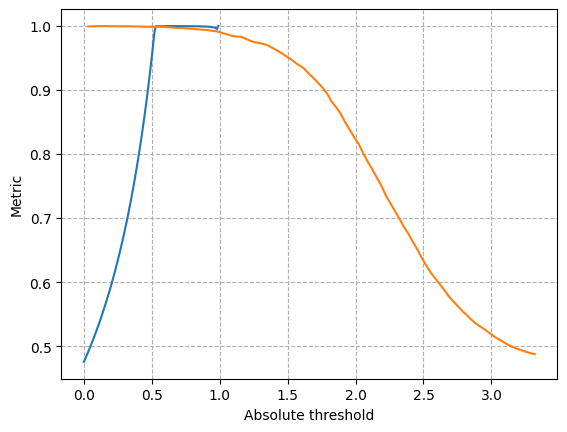

In [82]:
def rejection_base(correct, reject_order, unc_ary, metric, unc_type, relative=True, seed=44,
                   space_start=0.001, space_stop=0.99, space_bins=100, num_labels: Optional[int] = None, ax=None, **plt_kwargs):
    """Plot 3 metrics for varying rejection percentage and return axis.

    Parameters
    ----------
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    reject_order : ArrayLike
        1D array (`float` type) containing indices to reject, first index rejected first.
    unc_ary : ndarray
        1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
    metric : {'nra', 'cq', 'rq'}
        Metric to calculate.
    unc_type : {'entropy', 'confidence'}
        Type of uncertainty values.
    relative : bool, optional
        Whether to use a relative or absolute threshold.
        Default: True
    seed: int, optional
        Seed value for random rejection.
        Default 44
    space_start : float, optional
        At which threshold value to start figure.
        Default: 0.001
    space_stop : float, optional
        At which threshold value to stop figure.
        Default: 0.99
    space_bins : int, optional
        Number of evaluation points in the line plot.
        Default: 100
    num_labels : int, optional
        Number of labels for entropy uncertainty.
        Default: None
    ax : Axes, optional
        Matplotlib Axes object.
        Default: None

    Returns
    -------
    Axes
        Matplotlib Axes object.

    Raises
    ------
    ValueError
        If `unc_type` is invalid.
    """
    unc_types = ['entropy', 'confidence']
    if unc_type not in unc_types:
        raise ValueError(
            "Invalid uncertainty type. Expected one of: %s" % unc_types)
    if relative:
        treshold_ary = np.linspace(start=space_start, stop=space_stop, num=space_bins)
        reject_ary = treshold_ary
        plot_ary = treshold_ary
    elif not relative and unc_type == 'confidence':
        treshold_ary = np.linspace(start=(1-space_start), stop=(1-space_stop), num=space_bins)
        reject_ary = treshold_ary
        plot_ary = np.flip(treshold_ary, axis=0)
    elif not relative and unc_type == 'entropy':
        if num_labels is not None:
            max_entropy = np.log2(num_labels)
        else:
            max_entropy = np.max(unc_ary)
        treshold_ary = np.linspace(start=(1-space_start)*max_entropy, stop=(1-space_stop)*max_entropy, num=space_bins)
        reject_ary = treshold_ary
        plot_ary = treshold_ary

    compute_metrics_rej_v = np.vectorize(compute_metrics_rej, excluded=["correct",
                                                                        "reject_order", "unc_ary",
                                                                        "show", "relative", "seed"])
    nonrej_acc, class_quality, rej_quality = compute_metrics_rej_v(
        reject_ary, correct=correct, reject_order=reject_order, unc_ary=unc_ary,
        show=False, relative=relative, seed=seed)

    # plot on existing axis or new axis
    if ax is None:
        ax = plt.gca()
    if metric == "nra":
        ax.plot(plot_ary, nonrej_acc, **plt_kwargs)
    elif metric == "cq":
        ax.plot(plot_ary, class_quality, **plt_kwargs)
    elif metric == "rq":
        ax.plot(plot_ary, rej_quality, **plt_kwargs)

    if not relative and unc_type in ['TU', 'AU', 'EU']:
        ax.set_xlim(max_entropy+0.05*max_entropy, 0-0.05*max_entropy)
    return ax

# TODO: change name to e.g. rejection_plot
# TODO: 3 panels if metric is None, one for each panel
# TODO: 3 panels if uncertainty type is None, one for each panel (what with confidence?)
def rejection_setmetric_plot1(correct, reject_order, unc_ary, metric, unc_type,
                              relative=True, seed=44, space_start=0.001, space_stop=0.99,
                              space_bins=100, num_labels: Optional[int] = None, save=False, savefig_kwargs=None, plt_kwargs=None):
    """Plot 1 metric based on 1 uncertainties for varying rejection percentage and return 1 plot.

    Parameters
    ----------
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    reject_order : ArrayLike
        1D array (`float` type) containing indices to reject, first index rejected first.
    unc_ary : ndarray
        1D ndarray (`float` type) containing uncertainty values.
    metric : {'nra', 'cq', 'rq'}
        Metric to calculate.
    unc_type : {'TU', 'AU', 'EU', 'confidence'}
        Type of uncertainty values.
    relative : bool, optional
        Whether to use a relative or absolute threshold.
        Default: True
    seed: int, optional
        Seed value for random rejection.
        Default 44
    space_start : float, optional
        At which threshold value to start figure.
        Default: 0.001
    space_stop : float, optional
        At which threshold value to stop figure.
        Default: 0.99
    space_bins : int, optional
        Number of evaluation points in the line plot.
        Default: 100
    num_labels : int, optional
        Number of labels for entropy uncertainty.
        Default: None
    save : bool, optional
        Whether to save the figure.
        Default: False
    plt_kwargs : dict, optional
        Histogram properties.
        Default: None
    savefig_kwargs : dict, optional
        Figure saving properties.
        Default: None

    Raises
    ------
    ValueError
        If `unc_type` is invalid.
    """
    unc_types = ['TU', 'AU', 'EU', 'confidence']
    if unc_type not in unc_types:
        raise ValueError("Invalid uncertainty type. Expected one of: %s" % unc_types)
    unc_type = "entropy" if unc_type in ["TU", "AU", "EU"] else "confidence"
    if unc_type == 'confidence':
        unc_ary = (1. - unc_ary)
    # plt_kwargs, savefig_kwargs, *_ = kwargs_to_dict(plt_kwargs, savefig_kwargs) # TODO
    out_ax = rejection_base(correct, reject_order, unc_ary, metric, unc_type, relative,
                            seed, space_start, space_stop, space_bins, num_labels) # , **plt_kwargs)
    out_ax.grid(linestyle="dashed")
    if relative:
        out_ax.set(xlabel='Relative threshold', ylabel='Metric')
    else:
        out_ax.set(xlabel='Absolute threshold', ylabel='Metric')
    if save:
        plt.tight_layout()
        plt.savefig(**savefig_kwargs)
    return out_ax # TODO: return matplotlib fig instead of axis

rejection_setmetric_plot1(
    correct=y_pred_correct,
    reject_order=None,
    unc_ary=y_pred_uncertainty,
    metric="nra",
    unc_type="TU",
    relative=True,
    seed=44,
    space_start=0.001,
    space_stop=0.99,
    space_bins=100,
    num_labels=10,
    save=False,
    savefig_kwargs=None,
    plt_kwargs=None,
)

rejection_setmetric_plot1(
    correct=y_pred_correct,
    reject_order=None,
    unc_ary=y_pred_uncertainty,
    metric="nra",
    unc_type="TU",
    relative=False,
    seed=44,
    space_start=0.001,
    space_stop=0.99,
    space_bins=100,
    num_labels=10,
    save=False,
    savefig_kwargs=None,
    plt_kwargs=None,
)